## Part 1 implementing QAOA


### Question1 :
Write down in the cell below the Hamiltonian whose ground state is the solution to MaxCUT on an input graph $G=(V,E)$:

$$ H = \sum_{i,j\in E} \sigma_i \cdot \sigma_j $$

### Question 2:
Complete the implementation below of a simple, brute-force enumeration of all states computing the optimal solution to MaxCUT for the graph represented by 'edges'

In [1]:
import numpy as np

graph1 = [(0,1),(0,2),(1,3),(2,3)]
graph2 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
graph3 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
graph4 = [(0,1),(1,2),(2,3),(4,5),(5,6),(6,7),(0,4),(1,5),(2,6),(3,7)]
graph5 = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5),(1,4)]
graph6 = [(0,1),(0,2),(1,3),(2,4),(1,4)]


# choice of graph
edges = graph6

nqubits = max([max(list(v)) for v in edges])+1

#nqubits = 5
graph7 = [(i,(i+1)%nqubits) for i in range(nqubits)]+[(1,4)]


# COMPUTATION OF OPT.
best_value = len(edges)
best_b = 0
for x in range(2**nqubits):
    b = np.binary_repr(x, width=nqubits)
    b = [int(b[i]) for i in range(nqubits)]
    # TODO: Complete the computation below:
    
    val = sum([(1-2*int(b[i]))*(1-2*int(b[j])) for (i,j) in edges])

    # END TODO
    if val <= best_value:
        best_value = val
        best_b = b
print(best_value)
print(best_b)

-5
[1, 0, 0, 1, 1]


#### visualization of the graph

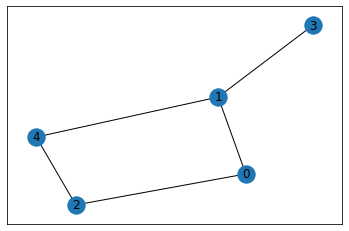

In [2]:
import networkx as nx
G = nx.Graph()
for i,j in edges:
    G.add_edge(i,j)
nx.draw_networkx(G)

In [3]:
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z

In [4]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

### Question 3

In [5]:
def one_qaoa_layer(n_qubits, edges, theta, beta):

    layer = QRoutine()
    #TODO: implement one qaoa layer
    for i in range(n_qubits):
        layer.apply(RX(theta), i)
    for i,j in edges:
      layer.apply(U_ZZ(2*beta), i, j)
    return layer

### Question 4

In [6]:
from qat.qpus import get_default_qpu

def evaluate_parameters(n_qubits, edges, parameters, n_layers):
    
    prog = Program()
    qubits = prog.qalloc(n_qubits)
    
    # TODO: implement initialization+parameterized circuit

    for i in qubits:
      prog.apply(H, i)

    for k in range(n_layers):
      prog.apply(one_qaoa_layer(n_qubits,edges, parameters[2*k], parameters[2*k+1]), qubits)
        
    # END TODO
    circ = prog.to_circ()
    
    job = circ.to_job()
    qpu = get_default_qpu()
    
    result = qpu.submit(job)
    
    # BEGIN TODO
    obs = 0
    for sample in result:
      b = sample.state.bitstring
      val = sum([(1-2*int(b[i]))*(1-2*int(b[j])) for (i,j) in edges])
      obs += val*sample.probability
        # this loop is over all 2**nqubits states.
        # sample.state.bitstring contains the qubit values (nqubits 0 or 1)

    # END TODO
    return obs
    
        

In [7]:
import numpy as np
np.random.random(3)

array([0.00765104, 0.33735919, 0.41199942])

In [8]:
from scipy.optimize import minimize


### Random initialisation

### Question 5: 
réponse à la question:

We need 7 layers.

-1.3783035831056134 -1.95373089129662 -2.884231148234203 -3.558304666362643 -3.7425021094935103 -3.8842854527971853 -4.108132369232516 -4.459726293835034 -4.616856244032858 -4.691456253472042 -4.747084623037334 -4.7723819537006245 -4.801807223904934 -4.803952778874196 -4.807659993463924 -4.813686591038581 -4.821540878446184 -4.827689907769623 -4.8338059735414 -4.837258998906961 -4.842440191385383 -4.848327504529136 -4.853034181901758 -4.859837504698769 -4.8667591396137215 -4.874008180743152 -4.884410131799297 -4.891278154814798 -4.89911992613155 -4.901396985462116 -4.903586378502045 -4.904548074879977 -4.905438727070993 -4.906284808687559 -4.907115925409677 -4.9084437135391354 -4.910120125769899 -4.91068534306745 -4.9110541888136785 -4.911225927063845 -4.91127030709642 -4.91128071599486 -4.911287786304676 -4.911299173047307 -4.911319527668228 -4.911357192752037 -4.9114265819072145 -4.911545372417088 -4.911683312464226 -4.9118238588854135 -4.912054136742624 -4.9123682895519085 -4.912444

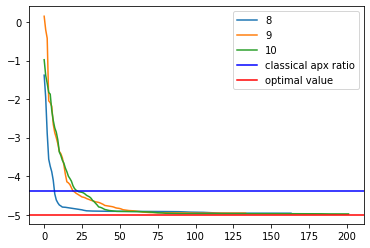

In [10]:
import matplotlib.pylab as plt


for nlayers in range(8,11,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

### Question 6: smart initialization

[0.4444444444444445, 0.1111111111111111]
[0.4444444444444445, 0.1111111111111111, 0.22222222222222224, 0.2222222222222222]
[0.4444444444444445, 0.1111111111111111, 0.22222222222222224, 0.2222222222222222, 0.0, 0.3333333333333333]
-0.6697966194628184 -2.5894956594383816 -2.962653612280213 -3.1890543705012577 -3.2242838809854915 -3.225495722597589 -3.2258949009251743 -3.2260389352793752 -3.2260682878373115 -3.2260693976552672 -3.226069642564603 -3.2260696472135812 -3.2260696472310015 [0.375, 0.0625]
[0.375, 0.0625, 0.25, 0.125]
[0.375, 0.0625, 0.25, 0.125, 0.125, 0.1875]
[0.375, 0.0625, 0.25, 0.125, 0.125, 0.1875, 0.0, 0.25]
-0.8069817104684212 -2.545685480494229 -2.9715733237927267 -3.251011173110982 -3.4437389654884645 -3.580160139389086 -3.86650010134971 -3.952532260193602 -4.064290156259075 -4.1093583139781975 -4.117835853014491 -4.118740678284035 -4.120208365729172 -4.122808355500696 -4.127575141120264 -4.136347986162333 -4.151482258508084 -4.162798886093445 -4.178749515637869 -4.20

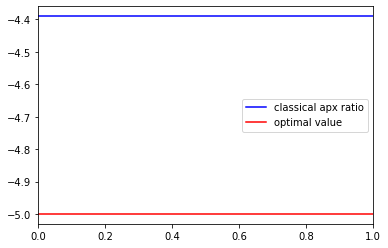

In [11]:
T = 1.

for nlayers in range(3,6,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init 
    parameters_init = []
    l = nlayers
    for k in range(1,l+1):
      theta = 2*T*(1-k/l)/l
      beta = T*k/l/l
      parameters_init.append(theta)
      parameters_init.append(beta)
      print(parameters_init)
    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()